In [2]:
#Script for making a nice pretty map of all the LCDRI data locations

from scipy.io import loadmat, savemat
from scipy import signal
from scipy.io import netcdf
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings


cdip_color='#F5B958'
red_color = '#D81159'
gray_color= '#2E2836'



In [3]:
fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
float_list = os.listdir(fname_base)


loc_storer = {}
#For each float, save a list of all locations + times, then sort that list, put it in a dictionary keyed by the 
#float id.
for float_id in float_list:
    
    if "grid" in float_id:
        continue
    if ".DS_" in float_id:
        continue
        
        
    dec_name = fname_base+float_id+"/dec/"
    
    #Loop through each profile for that float
    #pick out just the ctd files
    files = os.listdir(dec_name)
    gps_files = [file for file in files if "gps.mat" in file and not file.startswith('.')]
    lat_arr = np.array([])
    lon_arr = np.array([])
    t_arr = np.array([])


    
    counter=0
    #Load each profiling file, and then calculate the 1D spectrum
    for file in gps_files:
        fname = dec_name + file
        GPS = loadmat(fname)
        #float_id = str(file.split('-')[1])


        tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
        #Convert time to fractional year for use in the igrf function
        #frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
        with warnings.catch_warnings():
            avg_lat = np.nanmean(GPS["LAT"][0, :])
            avg_lon = np.nanmean(GPS["LON"][0, :])
            avg_uxt = np.nanmean(GPS["UXT_GPS"][0, :])
       
        lat_arr = np.append(lat_arr, np.array([avg_lat]))
        lon_arr = np.append(lon_arr, np.array([avg_lon]))
        t_arr = np.append(t_arr, np.array([avg_uxt]))
        
    
    out = zip(t_arr, lat_arr, lon_arr)
    sorted_array = sorted(out, key=lambda tup: tup[0])
    unzipped = ([ a for a,b,c in sorted_array ], [ b for a,b,c in sorted_array ], [c for a,b,c in sorted_array])
    
    t_arr = np.expand_dims(np.array(unzipped[0]), axis=1)
    lat_arr = np.expand_dims(np.array(unzipped[1]), axis=1)
    lon_arr = np.expand_dims(np.array(unzipped[2]), axis=1)

    
    stor_arr = np.hstack((t_arr, lat_arr, lon_arr))

    loc_storer[float_id] = stor_arr


        

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_52239/70879555.py:40: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_52239/70879555.py:41: RuntimeWarning: Mean of empty slice
  avg_lon = np.nanmean(GPS["LON"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_52239/70879555.py:40: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_52239/70879555.py:41: RuntimeWarning: Mean of empty slice
  avg_lon = np.nanmean(GPS["LON"][0, :])


In [4]:
#Load SWIFT Data


swift_folder = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/SWIFT/SWIFTprocessed/"

files = os.listdir(swift_folder)
swift_loc_storer = {}

for file in files:
    lat_arr = np.array([])
    lon_arr = np.array([])
    swift_fname = swift_folder+file
    name_tag = swift_fname.split('.')[0]
    SWIFT = loadmat(swift_fname)

    swift = np.transpose(SWIFT['SWIFT'])
    if swift.size==0:
        continue
    else:
        mdtype = swift.dtype
        ndata = {n: swift[n] for n in mdtype.names}
        columns = [n for (n, v) in ndata.items()]
        df = pd.DataFrame(np.concatenate([ndata[c] for c in columns], axis=1, dtype='object'), columns=columns)
        lat=np.array(df['lat'], dtype=float)
        lon=np.array(df['lon'], dtype=float)
        lat_arr = np.expand_dims(lat, axis=1)
        lon_arr = np.expand_dims(lon, axis=1)

        swift_loc_storer[name_tag] = np.hstack((lon_arr, lat_arr))
    
#Load CDIP Data
cdip_fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"

nc = netcdf.NetCDFFile(cdip_fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
cdip_lat = np.nanmean(nc.variables['gpsLatitude'][:])
cdip_lon = np.nanmean(nc.variables['gpsLongitude'][:])
Hs_cdip = nc.variables['waveHs'][:]
cdip_times = nc.variables['waveTime'][:]
cdip_dir = nc.variables['waveDp'][:]


#nc.close()
cdip_ts = np.array([datetime.datetime.fromtimestamp(t) for t in cdip_times])

#Load Bathymetry

#TID is not actually the z-depth, need to download a correct version of this bathymetry
bath_fname = '/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/gebco_2022_soCal.nc'
nc = netcdf.NetCDFFile(bath_fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
bath_lat= nc.variables['lat'][:]
bath_lon = nc.variables['lon'][:]
bath_z = nc.variables['elevation'][:]
#print(nc.variables)

minz=-1500
maxz=0

bath_z[bath_z<minz]=minz
bath_z[bath_z>maxz]=maxz



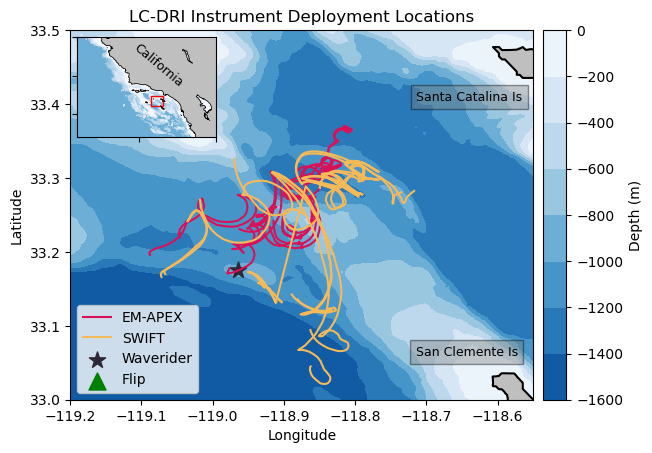

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.patches as patches


#Make Map (Figure 1)

fig, (ax) = plt.subplots(1, 1)
plt.title("LC-DRI Instrument Deployment Locations")
pc = ax.contourf(bath_lon, bath_lat, bath_z, cmap = 'Blues_r', vmin=-1800, vmax=0)
ax.contour(bath_lon,bath_lat,bath_z, levels=[-1], linestyles='solid', colors='k')
ax.contourf(bath_lon,bath_lat,bath_z, levels=[-2, 0], cmap='binary', vmin=-2, vmax=2)

ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
ax.set_xlim([-119.2, -118.55])
ax.set_ylim([33.0, 33.5])
lkey = '/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/SWIFT/SWIFTprocessed/SWIFT12_22Mar2017'
for key in loc_storer.keys():
    if key == '6667g':
        ax.plot(loc_storer[key][:, 2], loc_storer[key][:, 1], label="EM-APEX", color='#D81159')
    else:
        ax.plot(loc_storer[key][:, 2], loc_storer[key][:, 1], color='#D81159')


#plt.legend(loc=[1.05, -0.1])

#Plot swift
for key in swift_loc_storer.keys():
    if key == lkey:
        ax.plot(swift_loc_storer[key][:, 0], swift_loc_storer[key][:, 1], label="SWIFT", color='#F5B958')
    else:
        ax.plot(swift_loc_storer[key][:, 0], swift_loc_storer[key][:, 1], color='#F5B958')

        
#Pot cdip
ax.scatter(cdip_lon, cdip_lat, marker="*", s=150, c='#2E2836', label="Waverider")
ax.set_xlim([-119.2, -118.55])
ax.set_ylim([33.0, 33.5])


#Plot R/V Flip?
ax.scatter(np.nanmean(df['lon'])-360, np.nanmean(df['lat']), marker="^", s=150, c='green', label="Flip")

plt.legend(loc="lower left")


#Do some colorbar shit
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pc, cax=cax)
cbar.set_label("Depth (m)")




# Create inset of mixed specifications in the second subplot;
# width is 30% of parent axes' bounding box and
# height is 1 inch at the upper left corner (loc=2)
axins3 = inset_axes(ax, width="30%", height=1., loc=2)
axins3.contourf(bath_lon, bath_lat, bath_z, cmap = 'Blues_r', vmin=-3000, vmax=0)
axins3.contour(bath_lon,bath_lat,bath_z, levels=[-1], linewidths=0.5, linestyles='solid', colors='k')
axins3.contourf(bath_lon,bath_lat,bath_z, levels=[-2, 0], cmap='binary', vmin=-2, vmax=2)
axins3.set_xlim([-124, -115])
axins3.set_ylim([31.0, 37.5])
axins3.text(-120.5, 34.3, "California", size=9, rotation=-40)



#for key in loc_storer.keys():
#    axins3.plot(loc_storer[key][:, 2], loc_storer[key][:, 1], label=key, color='#D81159')
axins3.tick_params(labelleft=False, labelbottom=False)
#plt.legend(loc=[1.05, -0.1])


#Put a box in the inset
rect = patches.Rectangle((-119.2, 33), 0.75, 0.65, linewidth=1, edgecolor='r', facecolor='none')
axins3.add_patch(rect)

ax.text(-118.715, 33.06, "San Clemente Is", size=9, bbox=dict(facecolor='gray', alpha=0.4))
ax.text(-118.714, 33.405, "Santa Catalina Is", size=9, bbox=dict(facecolor='gray', alpha=0.4))





#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/LCDRI_Map.png", bbox_inches='tight')
plt.show()
#plt.legend()


In [3]:
#Load Flip data

flip = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/SWIFT/LCDRI.mat"

flip = loadmat(flip)
flip = flip['flip']
flip_temp = flip[0, 0]
mdtype = flip[0].dtype
ndata = {n: flip_temp[n] for n in mdtype.names}
columns = [n for (n, v) in ndata.items()]
df = pd.DataFrame(np.concatenate([ndata[c] for c in columns], axis=1, dtype='object'), columns=columns)
df['lon']=df['lon'].astype('float64')
df['lat']=df['lat'].astype('float64')
flip_times = pd.to_datetime(df['time']-719529, unit='D')

#Load ERA5 data
import xarray as xr
era = '/Users/jamesstadler/Documents/UW/TFO/Data/era5_bigger_domain.nc'
nc = netcdf.NetCDFFile(era, 'r', mmap=False)
data = xr.open_dataset('/Users/jamesstadler/Documents/UW/TFO/Data/era5_bigger_domain.nc')
lat = nc.variables['latitude'][:]
lon = nc.variables['longitude'][:]
swh = nc.variables['swh'][:]
era_time = nc.variables['time'][:]

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_52239/2563496334.py:29: RuntimeWarning: Mean of empty slice
  cset1 = ax1.contourf(data.longitude, data.latitude,np.nanmean(data.swh[start_ind:end_ind, :, :], axis=0), cmap='Purples')


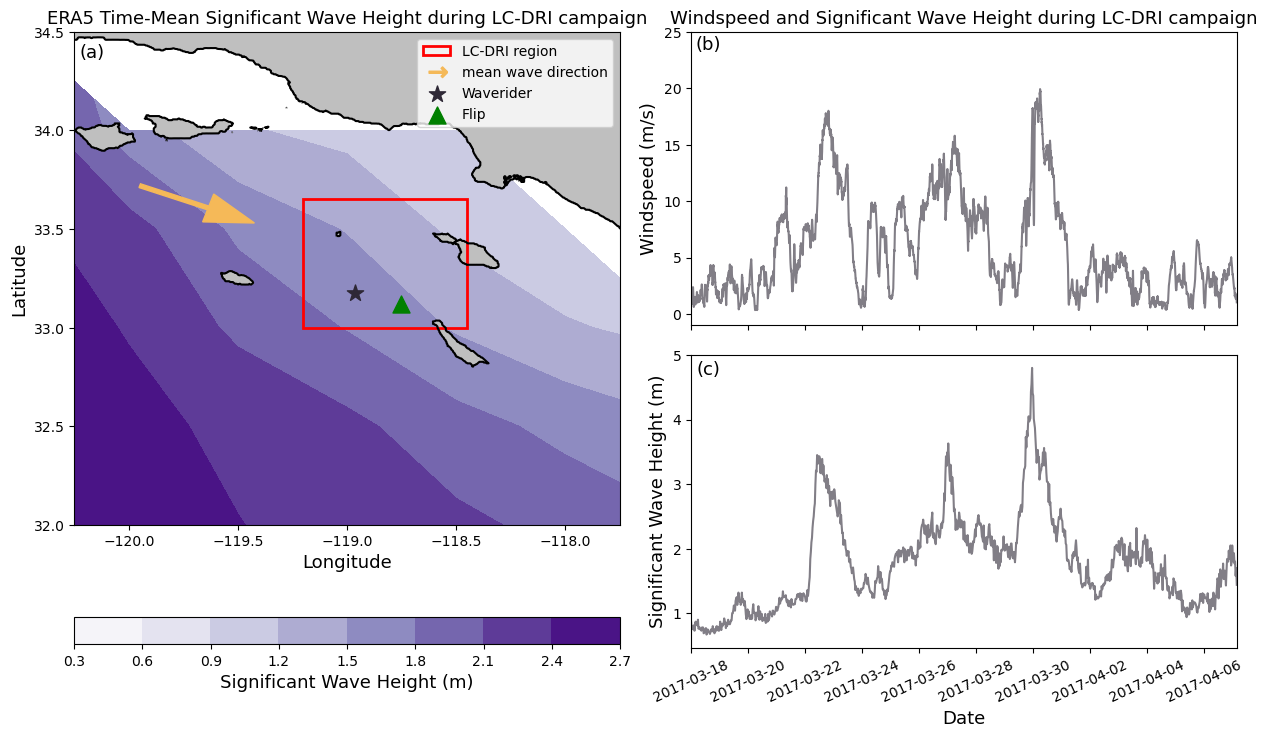

In [62]:
#Make Map (Figure 2)

#font size
fonts=13

#Get start and end time indicies for the ERA-5 data for averaging purposes
start_date = datetime.datetime.fromtimestamp(cdip_times[0])
end_date = datetime.datetime.fromtimestamp(cdip_times[-1])
start_np_time = np.datetime64(start_date)
end_np_time = np.datetime64(end_date)
start_ind = np.where(data.time.data>start_np_time)[0][0]
end_ind = np.where(data.time.data<end_np_time)[0][-1]


#Get mean cdip wave direction:
mean_cdip_dir = np.nanmean(cdip_dir[400:600])

# plt.figure(figsize=(15,30))
# fig, ax = plt.subplots(1, 2)
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.3)
gs.update(hspace=0.1)
plt.figure(figsize=(15, 8))
ax1 = plt.subplot(gs[:, :2])
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 2:])



cset1 = ax1.contourf(data.longitude, data.latitude,np.nanmean(data.swh[start_ind:end_ind, :, :], axis=0), cmap='Purples')
cbar = plt.colorbar(cset1, ax=ax1, orientation='horizontal', fraction=0.05)

#cbar = ax[0].set_colorbar()
cbar.set_label("Significant Wave Height (m)", fontsize=fonts, )
ax1.contour(bath_lon,bath_lat,bath_z, levels=[-1], linestyles='solid', colors='k')
ax1.contourf(bath_lon,bath_lat,bath_z, levels=[-2, 0], cmap='binary', vmin=-2, vmax=2)
#plt.colorbar()
ax1.set_xlim([-120.25, -117.75])
ax1.set_ylim([32, 34.5])
ax1.set_title("ERA5 Time-Mean Significant Wave Height during LC-DRI campaign", fontsize=fonts)
rect = patches.Rectangle((-119.2, 33), 0.75, 0.65, linewidth=2, edgecolor='r', facecolor='none', label='LC-DRI region')
ax1.add_patch(rect)
ax1.set_ylabel("Latitude", fontsize=fonts)
ax1.set_xlabel("Longitude", fontsize=fonts)


ax1.arrow(-119.95, 33.72, -(1/3)*np.sin(mean_cdip_dir*np.pi/180), -(1/3)*np.cos(mean_cdip_dir*np.pi/180), head_width=0.15, width=0.02,color=cdip_color)
#This is just a hack-y way of getting an arrow in the legend
ax1.scatter([-119.6], [33.6], marker=r'$\rightarrow$', s=200, color=cdip_color, label='mean wave direction')





#legend1.legendHandles[1]#._legmarker.set_markersize(15)
ax1.scatter(cdip_lon, cdip_lat, marker="*", s=150, c='#2E2836', label="Waverider")
ax1.scatter(np.nanmean(df['lon'])-360, np.nanmean(df['lat']), marker="^", s=150, c='green', label="Flip")
ax1.legend()
#legend = ax1.legend(markerscale=4)


#For getting uniformly-spaced x-axis
xtick_times = cdip_ts[0::100]

ax2.plot(flip_times, df['windu'].rolling(120).mean(), color=gray_color, alpha=0.6)
ax2.xaxis.set_tick_params(labelbottom=False)
ax2.xaxis.set_ticks(xtick_times)
ax3.plot(cdip_ts, Hs_cdip, color=gray_color, alpha=0.6)
ax3.xaxis.set_ticks(xtick_times) #set the ticks to be uniform
plt.xticks( rotation=25 )

ax3.set_xlim(cdip_ts[0], cdip_ts[-1])
ax2.set_xlim(cdip_ts[0], cdip_ts[-1])
ax2.set_ylim(-1, 25)
ax2.set_ylabel("Windspeed (m/s)", fontsize=fonts)
ax3.set_ylabel("Significant Wave Height (m)", fontsize=fonts)
ax3.set_xlabel("Date", fontsize=fonts)
ax2.set_title("Windspeed and Significant Wave Height during LC-DRI campaign", fontsize=fonts)

label_xcord = datetime.datetime.fromtimestamp(cdip_times[30])

ax3.annotate(text='(c)', xy=(label_xcord, 4.7), fontsize=fonts, ha="center")
ax2.annotate(text='(b)', xy=(label_xcord, 23.4), fontsize=fonts, ha="center")
ax1.annotate(text='(a)', xy=(-120.17, 34.37), fontsize=fonts, ha="center")


plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/wave_map.png", bbox_inches='tight')